In [89]:
import spynnaker.pyNN as p
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from brian2.units import *
import spynnaker_extra_pynn_models as q

In [90]:
p.setup(timestep=1.0, min_delay=1.0, max_delay=144.0)
n_neurons = 100

In [91]:
run_time = 1000 * ms
f_p1 = 50 * Hz
f_p2 = 10 * Hz
p_connection = .1

In [92]:
cell_params_lif = {'cm': 0.25,
                   'i_offset': 0.0,
                   'tau_m': 20.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 5.0,
                   'tau_syn_I': 5.0,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -50.0
                   }

In [93]:
weight_to_spike = 1.
delay = 1

In [94]:
p1 = p.Population(n_neurons, p.IF_curr_exp, cell_params_lif,
                   label='pop_1')
p2 = p.Population(n_neurons, p.IF_curr_exp, cell_params_lif,
                   label='pop_2')

In [95]:
stdp_model = p.STDPMechanism(
    timing_dependence = q.Vogels2011Rule(alpha=0.12,tau=20.0),
    weight_dependence = p.AdditiveWeightDependence(w_min=0.0, w_max=1.0, A_plus=0.05),
    mad=True
)

In [96]:
p.Projection(p1, p2, p.FixedProbabilityConnector(p_connection, weights=weight_to_spike), 
             target='inhibitory', label='inhib 1->2')#, synapse_dynamics=p.SynapseDynamics(slow=stdp_model))
p.Projection(p2, p1, p.FixedProbabilityConnector(p_connection, weights=weight_to_spike), 
             target='inhibitory', label='inhib 2->1')#, synapse_dynamics=p.SynapseDynamics(slow=stdp_model))

projection inhib 2->1

In [97]:
p.Projection(p1, p1, p.FixedProbabilityConnector(p_connection, weights=weight_to_spike), label='inhibit 1->1',
            target='inhibitory')
p.Projection(p2, p2, p.FixedProbabilityConnector(p_connection, weights=weight_to_spike), label='inhibit 2->2',
            target='inhibitory')

projection inhibit 2->2

In [98]:
p1.record_v()
p1.record_gsyn()
p1.record()
p2.record_v()
p2.record_gsyn()
p2.record()

In [99]:
# Input rates
p1_spike_times= np.linspace(0, run_time/ms, run_time * f_p1)
p2_spike_times= np.linspace(0, run_time/ms, run_time * f_p2)

t1 = p1_spike_times + run_time/ms
t2 = p2_spike_times + run_time/ms

d1 = t1 + run_time/ms 
d2 = t2 + run_time/ms

spikeArray_p1 = {'spike_times': np.concatenate((p1_spike_times,t2, d1))}
spikeArray_p2 = {'spike_times': np.concatenate((p2_spike_times,t1, d2))}

# Input populations
input_p1 = p.Population(1, p.SpikeSourceArray, spikeArray_p1,label='inputSpikes_p1')
input_p2 = p.Population(1, p.SpikeSourceArray, spikeArray_p2,label='inputSpikes_p2')

# Input connections
p.Projection(input_p1, p1, p.FixedProbabilityConnector(p_connection, weights=weight_to_spike), 
             label='excite input_p1->1')
p.Projection(input_p2, p2, p.FixedProbabilityConnector(p_connection, weights=weight_to_spike), 
             label='excite input_p2->2')

projection excite input_p2->2

In [100]:
p.run(3 * run_time/ms)

Allocating virtual identifiers
|0                           50%                         100%|
Partitioning graph vertices
|0                           50%                         100%|
Partitioning graph edges
|0                           50%                         100%|
Generating partitioner report
|0                           50%                         100%|
Filtering edges
|0                           50%                         100%|
Placing graph vertices
|0                           50%                         100%|
Generating placement report
|0                           50%                         100%|
Generating placement by core report
|0                           50%                         100%|
Generating SDRAM usage report
|0                           50%                         100%|
Routing
|0                           50%                         100%|
Allocating tags
|0                           50%                         100%|
Reporting Tags
|0                   

In [101]:
v_p1 = p1.get_v(compatible_output=True)
gsyn_p1 = p1.get_gsyn(compatible_output=True)
spikes_p1 = p1.getSpikes(compatible_output=True)
v_p2 = p2.get_v(compatible_output=True)
gsyn_p2 = p2.get_gsyn(compatible_output=True)
spikes_p2 = p2.getSpikes(compatible_output=True)
p.end()

Getting membrane voltage for pop_1
|0                           50%                         100%|
Getting conductance for pop_1
|0                           50%                         100%|
Getting spikes for pop_1
|0                           50%                         100%|
Getting membrane voltage for pop_2
|0                           50%                         100%|
Getting conductance for pop_2
|0                           50%                         100%|
Getting spikes for pop_2
|0                           50%                         100%|
Getting provenance data from machine graph
|0                           50%                         100%|
Getting provenance data
|0                           50%                         100%|
Getting Router Provenance
|0                           50%                         100%|
Extracting IOBUF
|0                           50%                         100%|


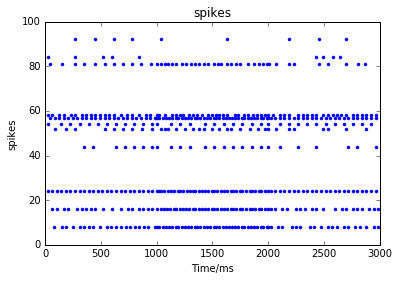

In [102]:
if spikes_p1 is not None:
#     print spikes_p1
    plt.figure()
    plt.plot([i[1] for i in spikes_p1], [i[0] for i in spikes_p1], ".")
    plt.xlabel('Time/ms')
    plt.ylabel('spikes')
    plt.title('spikes')

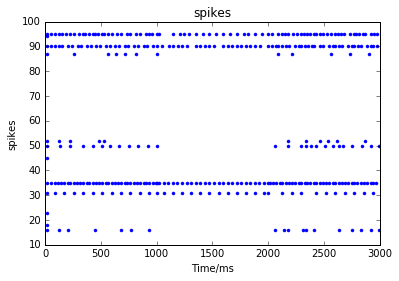

In [103]:
if spikes_p2 is not None:
#     print spikes_p1
    plt.figure()
    plt.plot([i[1] for i in spikes_p2], [i[0] for i in spikes_p2], ".")
    plt.xlabel('Time/ms')
    plt.ylabel('spikes')
    plt.title('spikes')

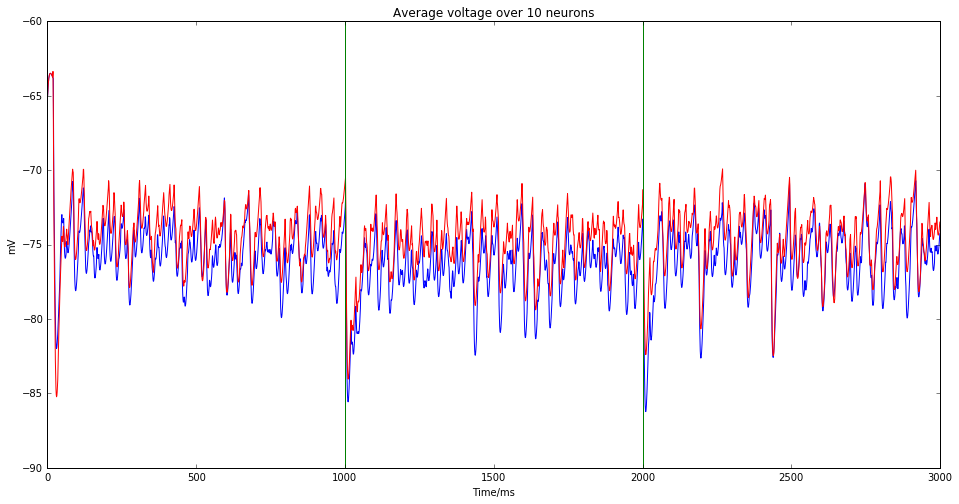

In [104]:
fig = plt.figure(figsize=(16,8))
plt.plot(np.average(v_p1[:, 2].reshape(100, 3000), axis=0), c='b')
plt.plot(np.average(v_p2[:, 2].reshape(100, 3000), axis=0), c='r')
plt.axvline(run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.axvline(2*run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.xlabel('Time/ms')
plt.ylabel('mV')
plt.title('Average voltage over 10 neurons')

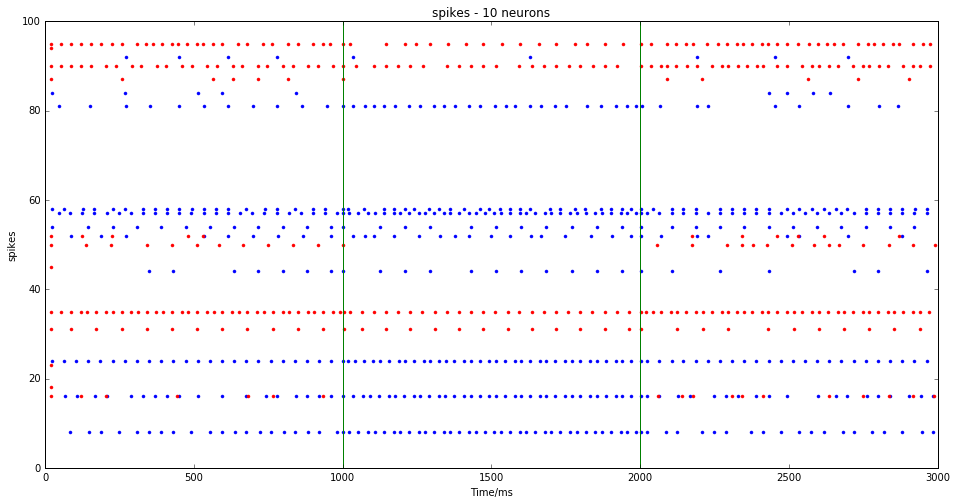

In [105]:
fig = plt.figure(figsize=(16,8))
plt.plot([i[1] for i in spikes_p1], [i[0] for i in spikes_p1], ".", c='b')
plt.plot([i[1] for i in spikes_p2], [i[0] for i in spikes_p2], ".", c='r')
plt.axvline(run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.axvline(2*run_time/ms, ls='-', c='g', lw=1, alpha=1)
plt.xlabel('Time/ms')
plt.ylabel('spikes')
plt.title('spikes - 10 neurons')